In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df_all = pd.read_csv('../../data/processed/WESAD/feature_extracted/30s/data_feature_engineered.csv', index_col=0)

In [3]:
selected_feature = [
    'HR_baseline_sub', 'hr_center', 'hr_zscore', 'RESP_rate', 'hr_resp_interaction',
    'hr_netacc_interaction', 'HR', 'IBI', 'arousal_index', 'EDA_mean',
    'eda_hr_interaction', 'net_acc_mean_sub', 'net_acc_mean', 'eda_resp_ratio', 'hrv_stress_index',
    'focus_label'
    ]

In [4]:
df = df_all[selected_feature]

In [5]:
df.head()

,HR_baseline_sub,hr_center,hr_zscore,RESP_rate,hr_resp_interaction,hr_netacc_interaction,HR,IBI,arousal_index,EDA_mean,eda_hr_interaction,net_acc_mean_sub,net_acc_mean,eda_resp_ratio,hrv_stress_index,focus_label
0,-12.639238,-12.639238,-1.345730,21.327375,1415.545722,4146.227502,66.372243,911.132812,741.047339,0.523506,34.746298,-0.880647,62.469299,0.005886,0.595642,1
1,-0.422634,-0.422634,-0.044999,22.168906,1742.228749,4907.269442,78.588847,803.631757,906.047629,0.520051,40.870200,-0.907633,62.442314,0.013768,0.976977,1
2,-13.923408,-13.923408,-1.482459,24.011434,1562.857969,4073.001086,65.088073,940.020161,770.658757,0.493109,32.095491,-0.773181,62.576766,0.004064,0.676597,1
3,-13.249864,-13.249864,-1.410745,20.909046,1375.012643,4127.344249,65.761617,924.316406,646.969837,0.470519,30.942103,-0.587739,62.762208,0.007608,0.650496,1
4,-2.807134,-2.807134,-0.298882,22.165715,1689.123832,4776.040885,76.204346,822.482639,748.091592,0.442887,33.749942,-0.675820,62.674127,0.003777,1.112837,1


In [6]:
df.describe()

,HR_baseline_sub,hr_center,hr_zscore,RESP_rate,hr_resp_interaction,hr_netacc_interaction,HR,IBI,arousal_index,EDA_mean,eda_hr_interaction,net_acc_mean_sub,net_acc_mean,eda_resp_ratio,hrv_stress_index,focus_label
count,929.000000,929.000000,929.000000,929.000000,929.000000,929.000000,929.000000,929.000000,929.000000,929.000000,929.000000,929.000000,929.000000,929.000000,929.000000,929.000000
mean,0.048891,0.048891,0.003299,21.915313,1923.130293,5557.327458,87.287563,749.207093,3789.438800,1.843233,168.104729,0.000869,63.676475,0.024172,0.774804,0.485468
std,12.970994,12.970994,0.993502,2.595939,435.922924,907.649031,14.229296,117.422965,5274.378008,2.364749,224.206951,0.505352,0.891016,0.047125,0.145866,0.500058
min,-33.239231,-33.239231,-2.486957,16.181853,1037.897460,3471.493025,52.876293,440.998134,125.872433,0.092480,6.961599,-2.512682,62.283237,0.000114,0.554398,0.000000
25%,-9.914507,-9.914507,-0.800358,20.009528,1591.525779,4885.295127,76.712152,666.903409,530.835215,0.290432,24.307823,-0.239146,63.010026,0.001729,0.686972,0.000000
50%,-0.863929,-0.863929,-0.087916,22.089410,1891.538499,5468.563790,86.247518,745.592949,1318.011538,0.768682,64.789870,-0.036313,63.314161,0.006162,0.742035,0.000000
75%,8.533458,8.533458,0.787815,24.006859,2212.067309,6163.714616,96.932441,825.446429,5810.373957,2.812219,263.973560,0.212572,64.404390,0.024612,0.816455,1.000000
max,42.691512,42.691512,2.812144,28.044069,3394.718011,8613.699793,137.440788,1139.423077,37683.130779,14.787926,1474.272902,5.270943,68.620890,0.551698,1.882595,1.000000


In [8]:
df.columns

Index(['HR_baseline_sub', 'hr_center', 'hr_zscore', 'RESP_rate',
       'hr_resp_interaction', 'hr_netacc_interaction', 'HR', 'IBI',
       'arousal_index', 'EDA_mean', 'eda_hr_interaction', 'net_acc_mean_sub',
       'net_acc_mean', 'eda_resp_ratio', 'hrv_stress_index', 'focus_label'],
      dtype='object')

### Check missing value

In [9]:
missing_value_count = df_all.isnull().sum()
missing_value_count

ACC_x_mean                   0
ACC_y_mean                   0
ACC_z_mean                   0
net_acc_mean                 0
net_acc_std                  0
EDA_mean                     0
EDA_std                      0
EDA_slope                    0
RESP_rate                    0
RESP_regularity              0
HR                           0
IBI                          0
RMSSD                        0
SDNN                         0
pNN50                        0
lf/hf                        0
label                        0
subject                      0
focus_label                  0
hr_diff                      0
hr_center                    0
hr_slope                     0
hr_zscore                    0
sdnn_diff                    0
sdnn_slope                   0
sdnn_zscore                  0
acc_ratio                    0
net_acc_mean_slope           0
net_acc_mean_diff            0
acc_vector_magnitude_mean    0
acc_vector_slope             0
hr_netacc_interaction        0
hr_sdnn_

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

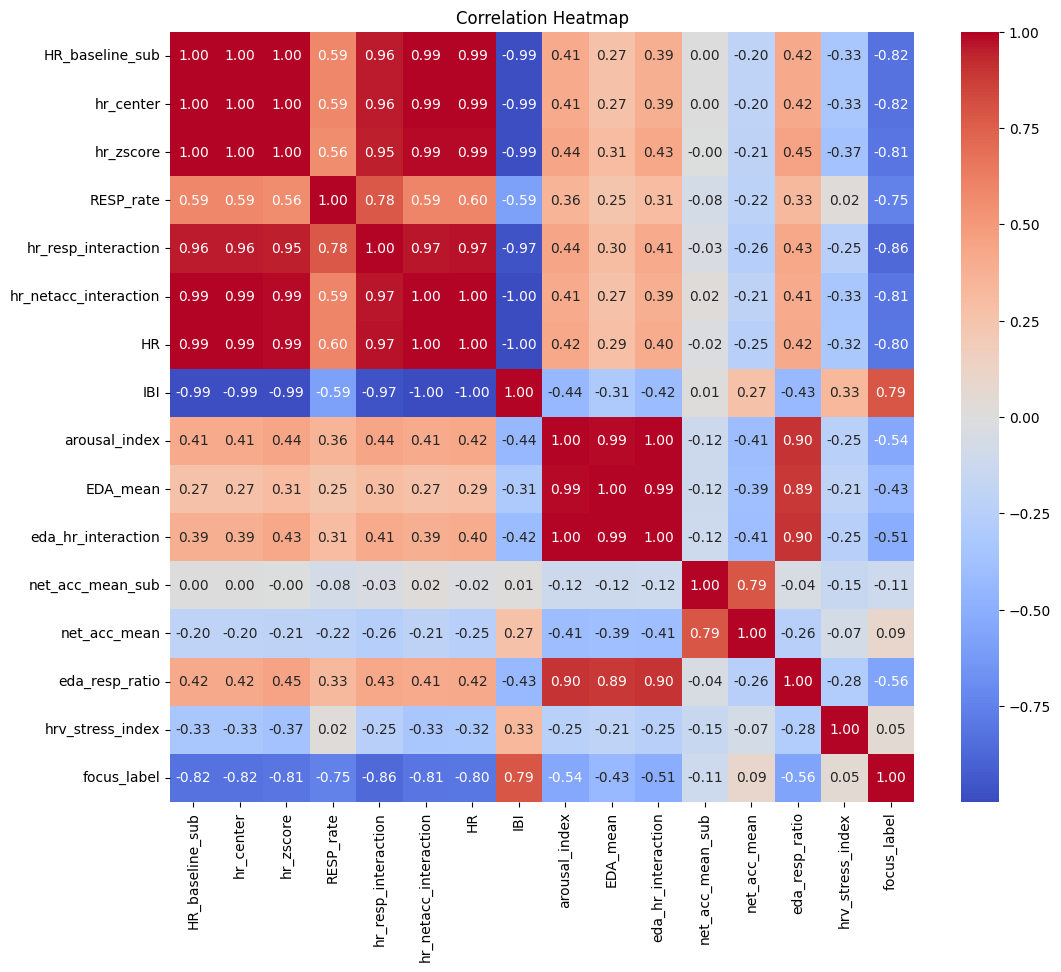

In [11]:
feature_only = df.corr()# Heatmap plot
plt.figure(figsize=(12, 10))
sns.heatmap(feature_only.corr(), annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title("Correlation Heatmap")
plt.show()

In [14]:
X = df_all.drop(columns=['focus_label'])
y = df_all.focus_label

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [17]:
pipeline = Pipeline([
    ('preprocess', StandardScaler()),
    ('model', RandomForestClassifier(class_weight='balanced', random_state=42))
])

In [18]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocess', StandardScaler()),
                ('model',
                 RandomForestClassifier(class_weight='balanced',
                                        random_state=42))])

In [19]:
y_pred = pipeline.predict(X_test)

In [20]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99        96
           1       1.00      0.98      0.99        90

    accuracy                           0.99       186
   macro avg       0.99      0.99      0.99       186
weighted avg       0.99      0.99      0.99       186



In [21]:
train_score = pipeline.score(X_train, y_train)
test_score = pipeline.score(X_test, y_test)

In [22]:
print(f'Train score\t: {train_score}')
print(f'Test score\t: {test_score}')

Train score	: 1.0
Test score	: 0.989247311827957


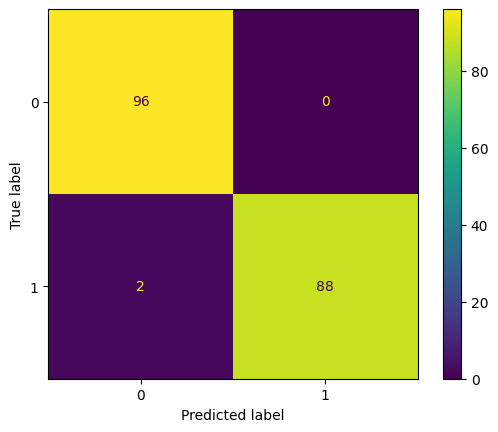

In [23]:
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()